In [26]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from tqdm import tqdm # progress bar

import skimage
import cv2

from glob import glob

from torchsummary import summary

import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [27]:
#########################################
# Parameters 
#########################################

viz_image_paths = glob('/Users/racoon/Downloads/open-images-sample/*.jpg')
training_image_paths = glob('/data/open-images-dataset/train/*.jpg')
validation_image_paths = glob('/data/open-images-dataset/validation/*.jpg')

train_dataset_length = 409600
validation_dataset_length = 20480
train_batch_size = 1024
validation_batch_size = 1024
num_epochs = 1500
save_after_epochs = 1 
backup_after_epochs = 5 
model_save_prefix = "variation_b"
reuse_image_count = 4

patch_dim = 32
gap = 10
jitter = 5

learn_rate = 0.0001
momentum = 0.974
weight_decay = 0.0005




In [28]:
#########################################
# Utilities 
#########################################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for i, t in enumerate(tensor):
            t.mul_(self.std[i%3]).add_(self.mean[i%3])
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))




In [34]:
#########################################
# This class generates patches for training
#########################################

patch_order_arr = [
  (0, 1, 2, 3),
  (0, 1, 3, 2),
  (0, 2, 1, 3),
  (0, 2, 3, 1),
  (0, 3, 1, 2),
  (0, 3, 2, 1),
  (1, 0, 2, 3),
  (1, 0, 3, 2),
  (1, 2, 0, 3),
  (1, 2, 3, 0),
  (1, 3, 0, 2),
  (1, 3, 2, 0),
  (2, 0, 1, 3),
  (2, 0, 3, 1),
  (2, 1, 0, 3),
  (2, 1, 3, 0),
  (2, 3, 0, 1),
  (2, 3, 1, 0),
  (3, 0, 1, 2),
  (3, 0, 2, 1),
  (3, 1, 0, 2),
  (3, 1, 2, 0),
  (3, 2, 0, 1),
  (3, 2, 1, 0)
]

class ShufflePatchDataset(Dataset):

  def __init__(self, image_paths, patch_dim, length, gap, jitter, transform=None):
    self.image_paths = image_paths
    self.patch_dim = patch_dim
    self.length = length
    self.gap = gap
    self.jitter = jitter
    self.transform = transform
    self.image_reused = 0
    
    self.sub_window_width = self.patch_dim + 2*self.jitter
    self.window_width = 2*self.sub_window_width
    
    self.min_image_width = self.window_width + 1

    self.saliency = cv2.saliency.StaticSaliencyFineGrained_create()

  def __len__(self):
    return self.length
  
  def half_gap(self):
    return math.ceil(self.gap/2)

  def random_jitter(self):
    return int(math.floor((self.jitter * 2 * random.random()))) - self.jitter

  def saliency_check(self, window, patch_coords):
    (success, saliency_map) = self.saliency.computeSaliency(cv2.cvtColor(window, cv2.COLOR_RGB2BGR))

    high_saliency_patches = 0
    med_saliency_patches = 0
    for p in patch_coords:
        patch_saliency_map = saliency_map[p[0]:p[0]+self.patch_dim, p[1]:p[1]+self.patch_dim]
        patch_saliency = np.sum(patch_saliency_map > .5)
        print('patch_saliency', patch_saliency)
        if patch_saliency >= 500:
          high_saliency_patches += 1
        elif patch_saliency >= 100:
          med_saliency_patches += 1

    print('salient_patches', high_saliency_patches, med_saliency_patches, high_saliency_patches > 0 and (high_saliency_patches + med_saliency_patches) > 2)
    return high_saliency_patches > 0 and (high_saliency_patches + med_saliency_patches) > 2


  def __getitem__(self, index):
    # [y, x, chan], dtype=uint8, top_left is (0,0)
    
    image_index = int(math.floor((len(self.image_paths) * random.random())))
    
    if self.image_reused == 0:
      pil_image = Image.open(self.image_paths[image_index]).convert('RGB')
      self.pil_image = pil_image.resize((int(round(pil_image.size[0]/3)), int(round(pil_image.size[1]/3))))
      self.image_reused = reuse_image_count
    else:
      self.image_reused -= 1

    image = np.array(self.pil_image)

    # If image is too small, try another image
    if (image.shape[0] - self.min_image_width) <= 0 or (image.shape[1] - self.min_image_width) <= 0:
        return self.__getitem__(index)
    
    window_y_coord = int(math.floor((image.shape[0] - self.window_width) * random.random()))
    window_x_coord = int(math.floor((image.shape[1] - self.window_width) * random.random()))

    window = image[window_y_coord:window_y_coord+self.window_width, window_x_coord:window_x_coord+self.window_width]
    order_label = int(math.floor((24 * random.random()))) 
    
    patch_coords = [
      (0, 0),
      (0, self.sub_window_width),
      (self.sub_window_width, 0),
      (self.sub_window_width, self.sub_window_width),
    ]

    patch_coords = [pc for _,pc in sorted(zip(patch_order_arr[order_label],patch_coords))]

    if not self.saliency_check(window, patch_coords):
      return self.__getitem__(index)

    patch_a = window[patch_coords[0][0]:patch_coords[0][0]+self.patch_dim, patch_coords[0][1]:patch_coords[0][1]+self.patch_dim]
    patch_b = window[patch_coords[1][0]:patch_coords[1][0]+self.patch_dim, patch_coords[1][1]:patch_coords[1][1]+self.patch_dim]
    patch_c = window[patch_coords[2][0]:patch_coords[2][0]+self.patch_dim, patch_coords[2][1]:patch_coords[2][1]+self.patch_dim]
    patch_d = window[patch_coords[3][0]:patch_coords[3][0]+self.patch_dim, patch_coords[3][1]:patch_coords[3][1]+self.patch_dim]

    combined_label = np.array(order_label).astype(np.int64)
        
    if self.transform:
      patch_a = self.transform(patch_a)
      patch_b = self.transform(patch_b)
      patch_c = self.transform(patch_c)
      patch_d = self.transform(patch_d)

    return patch_a, patch_b, patch_c, patch_d, combined_label

In [35]:

##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = ShufflePatchDataset(training_image_paths, patch_dim, train_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=train_batch_size,
                                          num_workers=4,
                                          shuffle=False)


valdataset = ShufflePatchDataset(validation_image_paths, patch_dim, validation_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=validation_batch_size,
                                        num_workers=4,
                                        shuffle=False)


vizdataset = ShufflePatchDataset(viz_image_paths, patch_dim, 1, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

vizloader = torch.utils.data.DataLoader(vizdataset,
                                        batch_size=1,
                                        shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


patch_saliency 45
patch_saliency 151
patch_saliency 406
patch_saliency 217
salient_patches 0 3 False
patch_saliency 641
patch_saliency 33
patch_saliency 347
patch_saliency 522
salient_patches 2 1 True


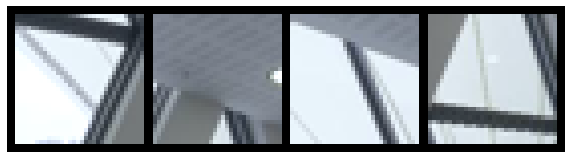

Labels: [14]


In [89]:
#############################
# Visualizing validation dataset
#############################

example_batch_val = next(iter(vizloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1]),unorm(example_batch_val[2]),unorm(example_batch_val[3])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[4].numpy()}')


In [24]:
##################################################
# Model for learning patch position
##################################################

class VggNetwork(nn.Module):
  def __init__(self,aux_logits = False):

      super(VggNetwork, self).__init__()

      self.cnn = nn.Sequential(

        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64), 
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128), 
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256), 
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2)
        
      )
    
      self.fc6 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.ReLU(True),
        nn.Dropout(),
      )

      self.fc = nn.Sequential(
        nn.Linear(4*1024, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 24),
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, patch_a, patch_b, patch_c, patch_d):
    output_fc6_patch_a = self.forward_once(patch_a)
    output_fc6_patch_b = self.forward_once(patch_b)
    output_fc6_patch_c = self.forward_once(patch_c)
    output_fc6_patch_d = self.forward_once(patch_d)

    output = torch.cat((output_fc6_patch_a, output_fc6_patch_b, output_fc6_patch_c, output_fc6_patch_d), 1)
    output = self.fc(output)

    return output, output_fc6_patch_a, output_fc6_patch_b, output_fc6_patch_c, output_fc6_patch_d

model = VggNetwork().to(device)
summary(model, [(3, 32, 32), (3, 32, 32), (3, 32, 32), (3, 32, 32)])



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12